This jupyter notebooks provides the code for classifying signals using the Continuous Wavelet Transform and Convolutional Neural Networks.
To get some more background information, please have a look at the accompanying blog-post:
http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

In [1]:
import pywt
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from collections import defaultdict, Counter

import datetime, time

import tensorflow as tf
from tensorflow import keras

from keras.layers.experimental import preprocessing
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten
from keras.models import Sequential
from keras.callbacks import History 


from tensorflow.keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


Using TensorFlow backend.


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Load Dataset

In [3]:
# Load Triaining and Testing Datasets
file_path = '/storage/data/mit-bih'
file_name = 'mit_bih_data_set.csv'
dataset_path = os.path.join(file_path,file_name)
data_set = pd.read_csv(dataset_path,dtype=float)
num_classes=6
data_set_np = data_set.to_numpy()
X = data_set_np[:,:-1]
y = data_set_np[:,-1]

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [4]:
X.shape

(42020, 319)

Text(0.5, 1.0, 'Scalogram')

<Figure size 432x288 with 0 Axes>

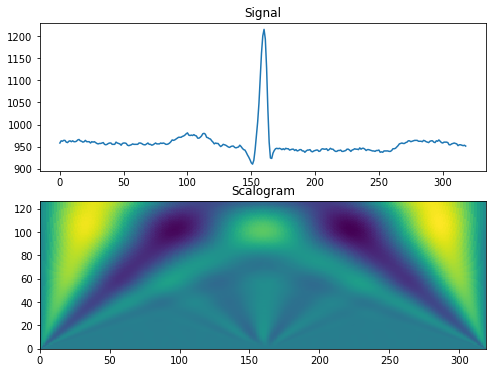

In [5]:
scales = range(1,128)
wav = pywt.ContinuousWavelet('morl')
fs = 360
scalogram, freq = pywt.cwt(X[0], scales, wav, sampling_period = 1/fs)

plt.figure()
plt.subplots(2, figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(np.arange(X.shape[1]),X[0])
plt.title('Signal')
plt.subplot(2, 1, 2)
plt.pcolormesh(scalogram)
plt.title('Scalogram')

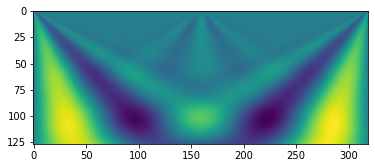

In [6]:
plt.imshow(scalogram)

## 2. Applying a CWT to ECG signals and saving the resulting scaleogram into an numpy ndarray

In [7]:
train_data = np.ndarray(shape=(X_trn.shape[0], np.size(scales), X_trn.shape[1]))
test_data = np.ndarray(shape=(X_tst.shape[0], np.size(scales), X_tst.shape[1]))

for i, signal in enumerate(X_trn):
    train_data[i], _ = pywt.cwt(X_trn[i], scales, wav, sampling_period = 1/fs)
    
for i, signal in enumerate(X_tst):
    test_data[i], _ = pywt.cwt(X_tst[i], scales, wav, sampling_period = 1/fs)    

In [8]:
train_data=train_data.astype('float32', copy=False)
test_data=test_data.astype('float32', copy=False)

In [9]:
m=np.mean(train_data)
s=np.std(train_data)

train_data = (train_data-m)/s
test_data = (test_data-m)/s

# prepare data for keras model
y_trn_oh = to_categorical(y_trn)
y_tst_oh = to_categorical(y_tst)

train_data = np.expand_dims(train_data, axis=3)
test_data = np.expand_dims(test_data, axis=3)

In [10]:
train_data.shape

(33616, 127, 319, 1)

In [11]:
train_data.dtype

dtype('float32')

## 3. Training a Convolutional Neural Network

In [12]:
epochs = 100
batch_size = 500

model = Sequential()

#Resize image by 8
model.add(preprocessing.Resizing(8,16))
model.add(Conv2D(8, 4, padding = 'same', activation='relu')) 
#model.add(Dropout(0.3))
model.add(MaxPooling2D(2, padding = 'same'))
#model.add(BatchNormalization())

model.add(Conv2D(8, 4, padding = 'same', activation='relu'))
#model.add(Dropout(0.3))
model.add(MaxPooling2D(2, padding = 'same'))
#model.add(BatchNormalization())

model.add(Conv2D(8, 4, activation='relu', padding = 'same'))
#model.add(Dropout(0.3))
#model.add(BatchNormalization())
model.add(MaxPooling2D(2, padding = 'same'))

model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.9)

opt = RMSprop(learning_rate=lr_schedule)

model.compile(loss='categorical_crossentropy', optimizer=opt, 
              metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=10),
            ModelCheckpoint(filepath='./best_model_cwt_resized.h5', monitor='val_accuracy', 
            save_best_only=True)]

# fit network
history=model.fit(train_data, y_trn_oh, epochs=epochs,callbacks=callbacks, 
                  batch_size=batch_size,validation_split=0.2)

model.load_weights('best_model_cwt_resized.h5')

train_score = model.evaluate(train_data, y_trn_oh)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(test_data, y_tst_oh)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Epoch 1/100
54/54 [==============================] - 12s 47ms/step - loss: 1.6398 - accuracy: 0.3055 - val_loss: 1.0178 - val_accuracy: 0.6563
Epoch 2/100
54/54 [==============================] - 2s 35ms/step - loss: 0.9850 - accuracy: 0.6528 - val_loss: 0.7791 - val_accuracy: 0.7168
Epoch 3/100
54/54 [==============================] - 2s 35ms/step - loss: 0.6353 - accuracy: 0.7842 - val_loss: 0.4232 - val_accuracy: 0.8859
Epoch 4/100
54/54 [==============================] - 2s 37ms/step - loss: 0.4556 - accuracy: 0.8688 - val_loss: 0.2763 - val_accuracy: 0.9267
Epoch 5/100
54/54 [==============================] - 2s 36ms/step - loss: 0.3471 - accuracy: 0.8994 - val_loss: 0.5172 - val_accuracy: 0.8391
Epoch 6/100
54/54 [==============================] - 2s 37ms/step - loss: 0.3444 - accuracy: 0.8952 - val_loss: 0.3164 - val_accuracy: 0.9078
Epoch 7/100
54/54 [==============================] - 2s 37ms/step - loss: 0.2977 - accuracy: 0.9116 - val_loss: 0.3162 - val_accuracy: 0.9035
Epoch

In [13]:
print(tf.config.experimental.get_memory_usage("GPU:0"))

31744


In [18]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4','5']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)

Accuracy: 98.02%


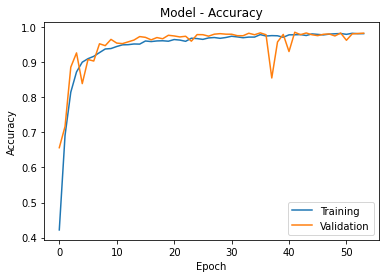

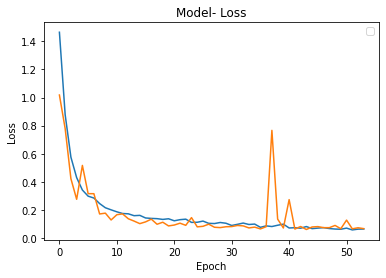

CPU times: user 5.73 s, sys: 3.11 s, total: 8.84 s
Wall time: 6.5 s


In [20]:
%%time
evaluate_model(history,test_data,y_tst_oh,model)
y_pred=model.predict(test_data)

In [21]:
with tf.device('/cpu:0'):
    start = time.time()
    model.predict(test_data)
    end = time.time()

inference_time =  (end-start)/test_data.shape[0]
throughput = test_data.shape[0]/(end-start)

print("Inference on CPU is :", inference_time)
print("Throughput on CPU is :", throughput, "sequence per second")

Inference on CPU is : 0.00021916656253565952
Throughput on CPU is : 4562.7398104457425 sequence per second


In [22]:
with tf.device('/gpu:0'):
    start = time.time()
    model.predict(test_data)
    end = time.time()

inference_time =  (end-start)/test_data.shape[0]
throughput = test_data.shape[0]/(end-start)

print("Inference on GPU is :", inference_time)
print("Throughput on GPU is :", throughput, "sequence per second")

Inference on GPU is : 0.0002334599889839677
Throughput on GPU is : 4283.389219506356 sequence per second


Normalized confusion matrix


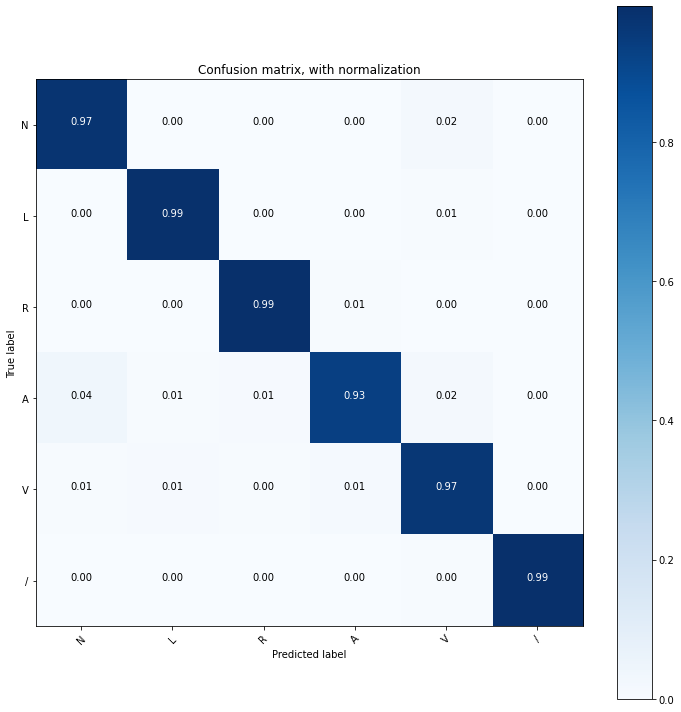

In [23]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_tst_oh.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'L', 'R', 'A', 'V', '/'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()    

Accuracy: 0.9802475011899096


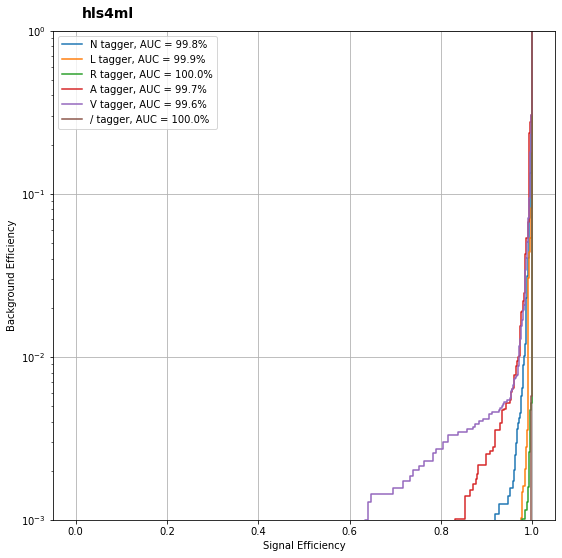

In [25]:
import plotting

classes = ['N', 'L', 'R', 'A', 'V', '/']

y_keras = model.predict(test_data)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_tst_oh, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9,9))
_ = plotting.makeRoc(y_tst_oh, y_keras, classes)

In [26]:
def get_flops(model):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()   

    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model)

            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        
            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)
        
            return flops.total_float_ops

get_flops('best_model_cwt_resized.h5')

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


4552

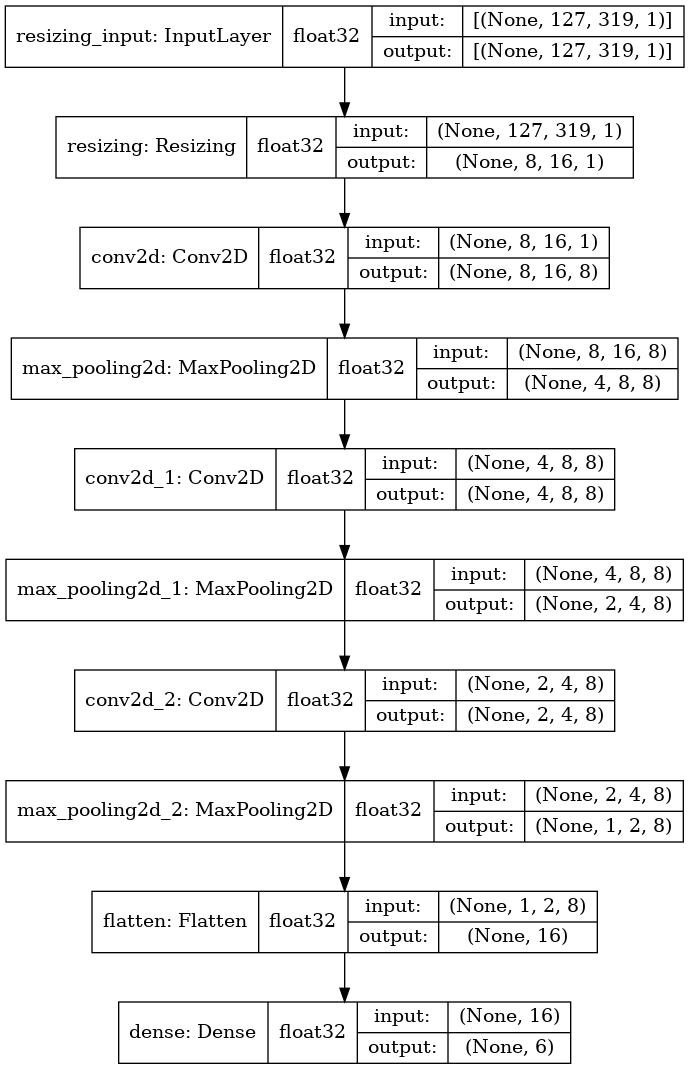

In [27]:
from keras.utils import plot_model
plot_model(model,show_shapes=True, show_dtype=True)
#tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 8, 16, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 16, 8)          136       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 8, 8)           1032      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 4, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 4, 8)           1032      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 2, 8)           0